### 1. Import Libraries

In [1]:
# To connect Jupyter Notebook to Hive
from pyhive import hive # Hive package

# To use pandas and numpy
import pandas as pd
import numpy as np

# For dashboard-like visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### 2. Connect Jupyter Notebook to Hive

In [61]:
conn = hive.Connection(
    host='localhost',
    port=10000,
    username='hive',  
    database='default'
)

cursor = conn.cursor()
cursor.execute("SELECT 1")
print(cursor.fetchall())

[(1,)]


### 3. Load the datasets

In [3]:
query1 = "SELECT * FROM df_delay LIMIT 100"
df_delay = pd.read_sql(query1, conn)
df_delay.head()

,df_delay.year,df_delay.month,df_delay.day_of_month,df_delay.day_of_week,df_delay.dep_time,df_delay.crs_dep_time,df_delay.arr_time,df_delay.crs_arr_time,df_delay.unique_carrier,df_delay.flight_num,...,df_delay.origin,df_delay.dest,df_delay.distance,df_delay.taxi_in,df_delay.taxi_out,df_delay.carrier_delay,df_delay.weather_delay,df_delay.nas_delay,df_delay.security_delay,df_delay.late_aircraft_delay
0,2004,1,12,1,623.0,630,901.0,915,UA,462,...,ORD,CLT,599,7,11,0.0,0.0,0.0,0.0,0.0
1,2004,1,13,2,621.0,630,911.0,915,UA,462,...,ORD,CLT,599,16,16,0.0,0.0,0.0,0.0,0.0
2,2004,1,14,3,633.0,630,920.0,915,UA,462,...,ORD,CLT,599,4,15,0.0,0.0,0.0,0.0,0.0
3,2004,1,15,4,627.0,630,859.0,915,UA,462,...,ORD,CLT,599,4,10,0.0,0.0,0.0,0.0,0.0
4,2004,1,16,5,635.0,630,918.0,915,UA,462,...,ORD,CLT,599,3,13,0.0,0.0,0.0,0.0,0.0


In [4]:
query2 = "SELECT * FROM df_cancelled LIMIT 100"
df_cancelled = pd.read_sql(query2, conn)
df_cancelled.head()

,df_cancelled.year,df_cancelled.month,df_cancelled.day_of_month,df_cancelled.day_of_week,df_cancelled.crs_dep_time,df_cancelled.crs_arr_time,df_cancelled.unique_carrier,df_cancelled.flight_num,df_cancelled.tail_num,df_cancelled.crs_elapsed_time,df_cancelled.origin,df_cancelled.dest,df_cancelled.distance,df_cancelled.taxi_in,df_cancelled.taxi_out,df_cancelled.cancelled,df_cancelled.cancellation_code
0,2004,1,26,1,630,915,UA,462,000000,105,ORD,CLT,599,0,0,1,B
1,2004,1,4,7,1505,1725,UA,463,000000,260,ORD,PDX,1739,0,0,1,C
2,2004,1,6,2,1505,1725,UA,463,000000,260,ORD,PDX,1739,0,0,1,B
3,2004,1,7,3,1510,1732,UA,463,000000,262,ORD,PDX,1739,0,0,1,C
4,2004,1,8,4,1510,1732,UA,463,000000,262,ORD,PDX,1739,0,0,1,B


## Data Analysis

### 1. Delay Patterns:

1. What times of day (morning/afternoon/evening) have the lowest average delays?
2. Which days of the week show better on-time performance?
3. During which months or seasons are flights most likely to be on time?

**Lowest Average Delays by time of day**

In [5]:
query = """
SELECT
    CASE
        WHEN crs_dep_time < 1200 THEN 'Morning'
        WHEN crs_dep_time < 1800 THEN 'Afternoon'
        ELSE 'Evening'
    END AS time_of_day,
    AVG(arr_delay) AS avg_arr_delay
FROM df_delay
GROUP BY
    CASE
        WHEN crs_dep_time < 1200 THEN 'Morning'
        WHEN crs_dep_time < 1800 THEN 'Afternoon'
        ELSE 'Evening'
    END
ORDER BY time_of_day
"""

df_time_of_day = pd.read_sql(query, conn)
df_time_of_day

,time_of_day,avg_arr_delay
0,Afternoon,8.599171
1,Evening,11.647742
2,Morning,1.772711


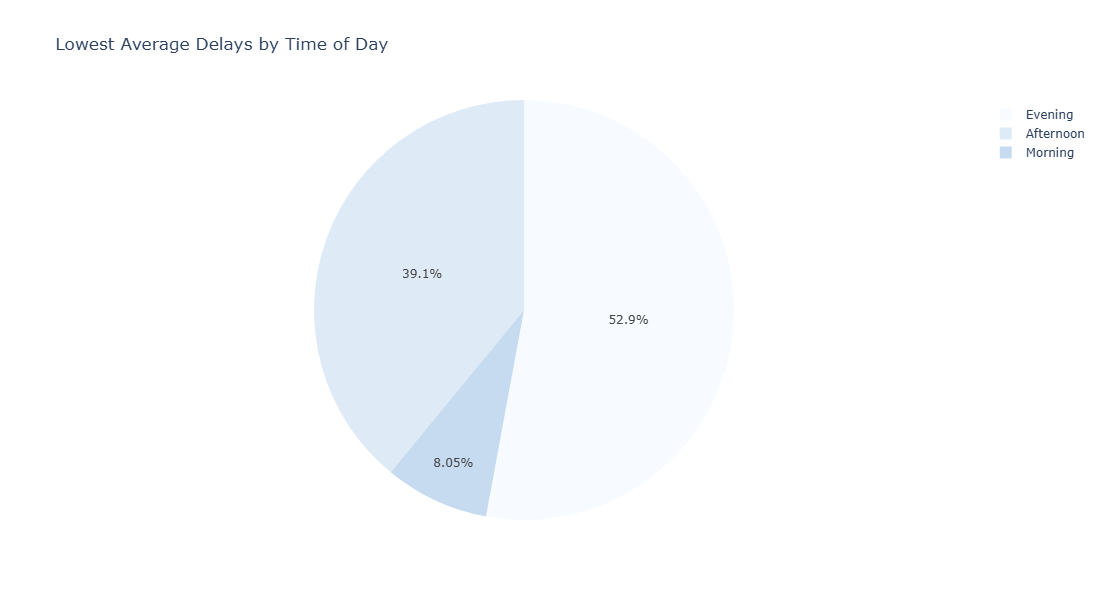

In [35]:
# Visualize the Lowest Average Delays by Time of Day
fig = px.pie(df_time_of_day, names='time_of_day', values='avg_arr_delay', title='Lowest Average Delays by Time of Day', 
             color_discrete_sequence=px.colors.sequential.Blues)
fig.update_layout(width=800, height=600)
fig.show()

***Morning flights tend to delay the least on average compared to Afternoon or Evening flights***

According to [Frommer's.com](https://www.frommers.com/tips/airfare/5-reasons-early-morning-flights-are-less-likely-to-be-delayed/), flights are less likely to be delayed in the morning because:
1. there is no need to wait for plane arrival from another destination
2. air traffic is lighter in the morning
3. there are lesser thunderstorms in the morning compared to in the afternoon or evening.
4. airlines prioritize early flights to stay on schedule because delays in early flights would mess up their whole day.

**Days of the week that shows better on-time performance**

In [7]:
query2 = """
SELECT
    day_of_week,
    AVG(arr_delay) AS avg_arr_delay
FROM df_delay
GROUP BY day_of_week
ORDER BY day_of_week
"""

df_day_of_week = pd.read_sql(query2, conn)
df_day_of_week

,day_of_week,avg_arr_delay
0,1,7.797879
1,2,5.510747
2,3,6.823174
3,4,7.938058
4,5,7.978558
5,6,2.649383
6,7,6.281599


**Note**: To get the actual day of the week, we are referencing [U.S. DOT/BTS](https://www.transtats.bts.gov/FieldInfo.asp?Svryq_Qr5p=QnB%FD1s%FDjrrx&Svryq_gB2r=a7z&Y11x72_gnoyr=Y_jRRXQNlf&gnoyr_VQ=FGJ&flf_gnoyr_anzr=g_bagVZR_eRcbegVaT&fB5_Svryq_anzr=QNl_bS_jRRX)

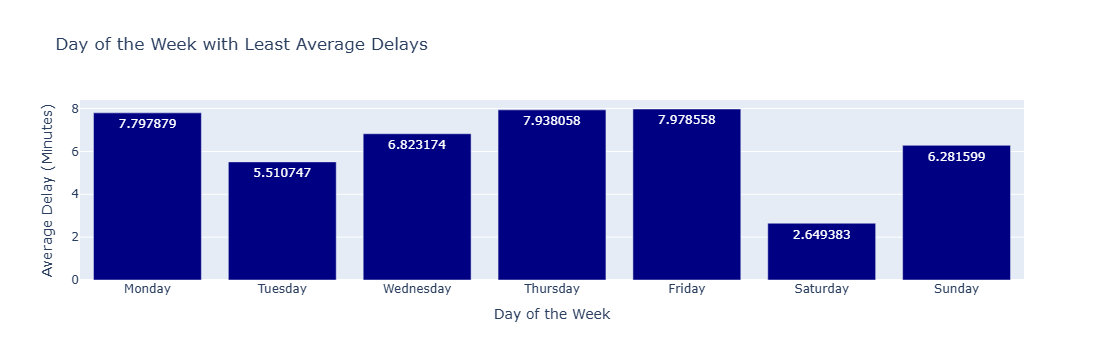

In [48]:
# Visualize Day with Least Delays

# Add day_names column
day_names = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

df_day_of_week['day_name'] = df_day_of_week['day_of_week'].map(day_names)

# Sort Sort by day_of_week in calendar order
df_day_of_week = df_day_of_week.sort_values('day_of_week')

# Plot with day_name
fig = px.bar(df_day_of_week,x='day_name',y='avg_arr_delay',title='Day of the Week with Least Average Delays',height=400,
    color_discrete_sequence=px.colors.sequential.Jet,text_auto=True)
fig.update_layout(xaxis_title="Day of the Week",yaxis_title="Average Delay (Minutes)")
fig.show()

Above is a bar chart that shows the average flight delays for each day of the week. From the plot, we can see that Saturdays usually has the lowest average delay of approximately 2.65 minutes, while Mondays, Thursdays and Fridays show the highest averages near 8 minutes. This suggests that flights on Saturdays generally experience fewer delays, likely due to reduced air traffic compared to other days of the week, when business travel and holiday travel peaks. Overall, Saturdays show better on-time performance compared to other days of the week.

**Months and seasons the flights are most likely on time**

In [10]:
query3 = """
SELECT
    month,
    AVG(arr_delay) AS avg_arr_delay
FROM df_delay
GROUP BY month
ORDER BY month
"""

df_month = pd.read_sql(query3, conn)
df_month

,month,avg_arr_delay
0,1,7.877413
1,2,5.953805
2,3,3.854649
3,4,2.732700
4,5,7.828581
5,6,11.353244
6,7,9.310871
7,8,7.133167
8,9,1.035359
9,10,4.051114


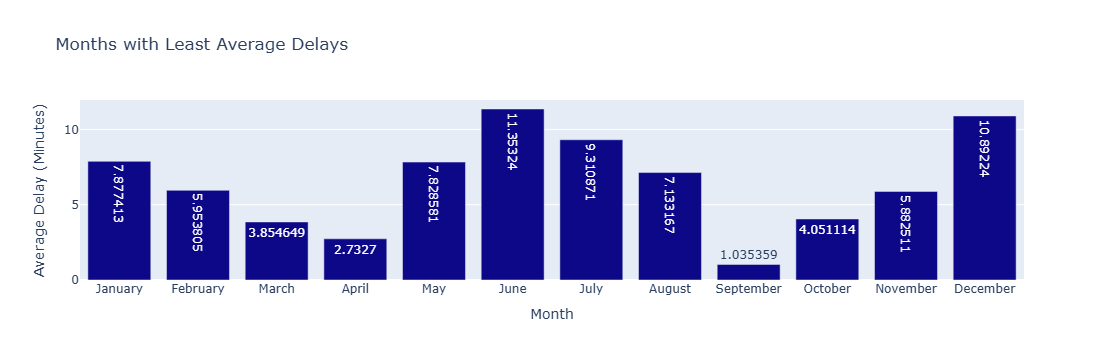

In [11]:
# Visualize Months/Seasons with least delays

# Add month_names column
month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df_month['month_name'] = df_month['month'].map(month_names)

# Sort month
df_month = df_month.sort_values('month')

# Plot with month_name
fig = px.bar(df_month, x='month_name', y='avg_arr_delay', title='Months with Least Average Delays', height=400,
    color_discrete_sequence=px.colors.sequential.Plasma, text_auto=True)
fig.update_layout(xaxis_title="Month", yaxis_title="Average Delay (Minutes)")
fig.show()

The analysis shows how average flight delays vary by month. 

+ Overall, September stands out as the month with the least average delays, recording just about 1 minute on average — likely due to fewer travelers and stable weather conditions. April and March also show relatively low average delays, under 4 minutes, making early spring an ideal time to fly with minimal disruptions.
+ In contrast, June and December have the highest average delays at around 11 and 10.9 minutes, respectively. This is expected as June marks the start of the summer travel peak, often accompanied by thunderstorms, while December brings heavy holiday travel and possible winter weather challenges.
+ The pattern suggests that peak vacation and holiday months (June–August and December) tend to have higher delays due to increased passenger volume and seasonal weather impacts. Meanwhile, off-peak months like September, and parts of spring, generally offer better on-time performance.

### 2. Delay Factors:

1. Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset.
2. Quantify the impact of each factor (in minutes of delay and percentage of total delays).

**a. Calculate total delay minutes per factor**

In [15]:
query4 = """SELECT
  SUM(carrier_delay) AS carrier_total,
  SUM(weather_delay) AS weather_total,
  SUM(nas_delay) AS nas_total,
  SUM(security_delay) AS security_total,
  SUM(late_aircraft_delay) AS late_aircraft_total
FROM df_delay
"""

df_trial = pd.read_sql(query4, conn)
df_trial.head()

,carrier_total,weather_total,nas_total,security_total,late_aircraft_total
0,18833073.0,5037460.0,24472354.0,179219.0,24566219.0


**b. Calculate grand total**

In [16]:
query5 = """SELECT
  SUM(carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay) AS total_delay_minutes
FROM df_delay
"""

df_total = pd.read_sql(query5, conn)
df_total

,total_delay_minutes
0,73088325.0


**c. Create Summary Table**

In [18]:
query6 = """
SELECT 'Carrier Delay' AS delay_type, 18833073 AS delay_minutes, 
       ROUND(18833073/73088325 * 100, 2) AS percent_of_total
UNION ALL
SELECT 'Weather Delay', 5037460, ROUND(5037460/73088325 * 100, 2)
UNION ALL
SELECT 'NAS Delay', 24472354, ROUND(24472354/73088325 * 100, 2)
UNION ALL
SELECT 'Security Delay', 179219, ROUND(179219/73088325 * 100, 2)
UNION ALL
SELECT 'Late Aircraft Delay', 24566219, ROUND(24566219/73088325 * 100, 2)
ORDER BY delay_minutes DESC
"""

summary_table = pd.read_sql(query6, conn)
summary_table

,_u1.delay_type,_u1.delay_minutes,_u1.percent_of_total
0,Late Aircraft Delay,24566219,33.61
1,NAS Delay,24472354,33.48
2,Carrier Delay,18833073,25.77
3,Weather Delay,5037460,6.89
4,Security Delay,179219,0.25


**Visualization: Proportion of Total Flight Delays by Factor**

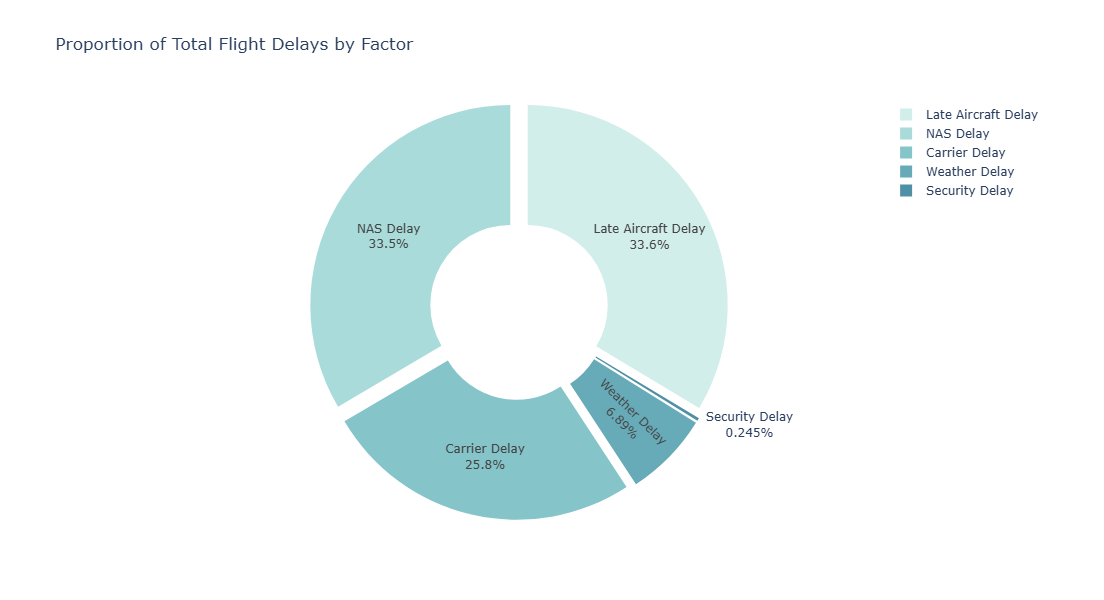

In [34]:
fig = px.pie(summary_table, names='_u1.delay_type', values='_u1.delay_minutes',
    title='Proportion of Total Flight Delays by Factor', color_discrete_sequence=px.colors.sequential.Teal, hole = 0.4)

fig.update_layout(width=800, height=600)

fig.update_traces(textinfo='percent+label', pull=[0.05]*len(summary_table))

fig.show()

From the above donut pie chart, we can say that:

In 2004, Late Aircraft Delays and National Aviation System, NAS Delays were the dominant factors driving flight delays, together accounting for over two-thirds of all delay time. Besides that, Carrier Delays accounted for roughly 26%, while Weather and Security delays were much smaller contributors. Even though this data is historical, analysing it in 2025 helps show where airlines and airports may have focused operational improvements over the past two decades. Understanding these patterns provides a valuable benchmark for measuring how much these categories have improved or changed in today’s aviation operations.

**Visualization: Total Delay Minutes by Factor**

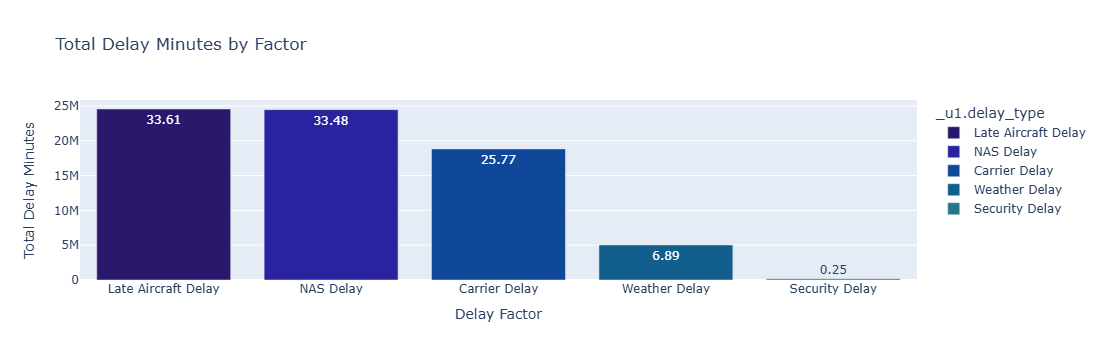

In [36]:
fig = px.bar(summary_table, x='_u1.delay_type', y='_u1.delay_minutes', text='_u1.percent_of_total', height = 500,
             title='Total Delay Minutes by Factor', color='_u1.delay_type',color_discrete_sequence=px.colors.sequential.haline)

fig.update_layout(xaxis_title="Delay Factor", yaxis_title="Total Delay Minutes")
fig.show()

This bar chart ranks the main factors that contributed to flight delays in 2004, based on total delay minutes and their percentage share.

In the 2004 dataset, operational issues such as late aircraft connections and NAS-related delays were the biggest drivers of total flight delay minutes. This pattern highlights where major efficiency gains and investments in air traffic management could have the biggest long-term impact, which can be a lesson that can be applied when comparing historical trends with improvements by 2025.

### 3. Cancellation Analysis
1. **Identify the primary reasons for flight cancellations as categorized in the dataset.**
2. **Determine if cancellations correlate with specific airlines, airports, or time periods.**

#### Primary Reasons for Flight Cancellations

In [37]:
query7 = """SELECT 
  cancellation_code,
  COUNT(*) AS num_cancelled
FROM df_cancelled
WHERE cancelled = 1
GROUP BY cancellation_code
ORDER BY num_cancelled DESC
"""

df_cancel_reasons = pd.read_sql(query7, conn)
df_cancel_reasons

,cancellation_code,num_cancelled
0,A,59352
1,B,44558
2,C,23732
3,D,115


**Note:** Cancellation codes are defined by the U.S. DOT/BTS.  
[Reference Link](https://www.transtats.bts.gov/FieldInfo.asp?Svryq_Qr5p=f2rpvsvr5%FDgur%FDern510%FDS14%FDPn0pryyn6v10&Svryq_gB2r=Pun4&Y11x72_gnoyr=Y_PNaPRYYNgVba&gnoyr_VQ=FGJ&flf_gnoyr_anzr=g_bagVZR_eRcbegVaT&fB5_Svryq_anzr=PNaPRYYNgVba_PbQR)

**Hence, the codes will be replaced by their actual meaning/representation for better understanding.**

In [42]:
# Map the Code to the meaning
df_cancel_reasons['cancellation_code'] = df_cancel_reasons['cancellation_code'].replace({
    'A': 'Carrier',
    'B': 'Weather',
    'C': 'NAS',
    'D': 'Security'
})

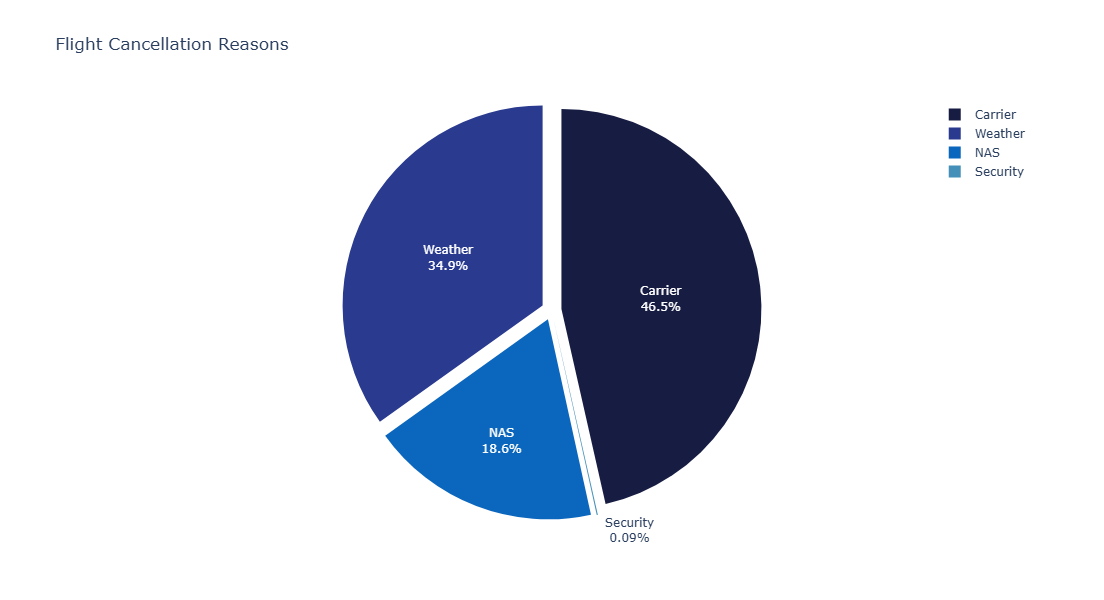

In [43]:
# Visualization
fig = px.pie(df_cancel_reasons, names='cancellation_code', values='num_cancelled',
    title='Flight Cancellation Reasons', color_discrete_sequence=px.colors.diverging.balance)

fig.update_layout(width=800, height=600)

fig.update_traces(textinfo='percent+label', pull=[0.05]*len(df_cancel_reasons))

fig.show()

This pie chart illustrates the proportion of flight cancellations in 2004 categorized by the U.S. Department of Transportation’s (DOT) standard cancellation codes:

+ A – Carrier: Cancellations due to airline-related problems such as mechanical issues, crew unavailability, or operational decisions.
+ B – Weather: Cancellations primarily driven by adverse weather conditions (e.g., storms, fog, or snow).
+ C – NAS (National Airspace System): Cancellations caused by air traffic control delays, heavy traffic volume, or system capacity constraints.
+ D – Security: Cancellations due to security concerns such as threats, lockdowns, or other security-related disruptions.

And from the pie chart, we can see that:
1. Carrier-related issues (Code A) were the largest contributor, making up ~46% of all cancellations in 2004. This suggests that airline operations and logistics were a significant driver of flight disruptions that year.
2. Weather-related cancellations (Code B) accounted for about 35%, highlighting how unpredictable weather conditions still heavily impacted flight reliability — a pattern that remains relevant today.
3. NAS delays (Code C) made up around 19%, reflecting the challenges within the national airspace system such as air traffic congestion or limited airport capacity.
4. Security-related cancellations (Code D) were negligible (<1%), indicating that in 2004, security issues were not a major factor in overall flight cancellations.

The analysis shows that while uncontrollable weather events still play an important role, operational efficiency within airlines (Carrier) was the top reason flights were cancelled in 2004. This insight can help modern airlines and airports prioritize resource planning, maintenance, and contingency strategies to reduce cancellations due to controllable factors.

#### Check if cancellations correlate with airlines, airports, or time

Based on the above analysis, we need to know:
1. Are some airlines more likely to cancel flights?
2. Are certain airports hotspots for cancellations?
3. Are cancellations more common in certain months, days, or times of day?

**a) Cancellations by Airline**

In [44]:
query8 = """SELECT
  unique_carrier AS airline,
  COUNT(*) AS cancelled_flights
FROM df_cancelled
WHERE cancelled = 1
GROUP BY unique_carrier
ORDER BY cancelled_flights DESC
"""

df_airline_cancel = pd.read_sql(query8, conn)
df_airline_cancel

,airline,cancelled_flights
0,MQ,17787
1,OH,13616
2,AA,12402
3,DL,10717
4,WN,10103
5,OO,9784
6,DH,8287
7,EV,7542
8,US,6779
9,UA,6548


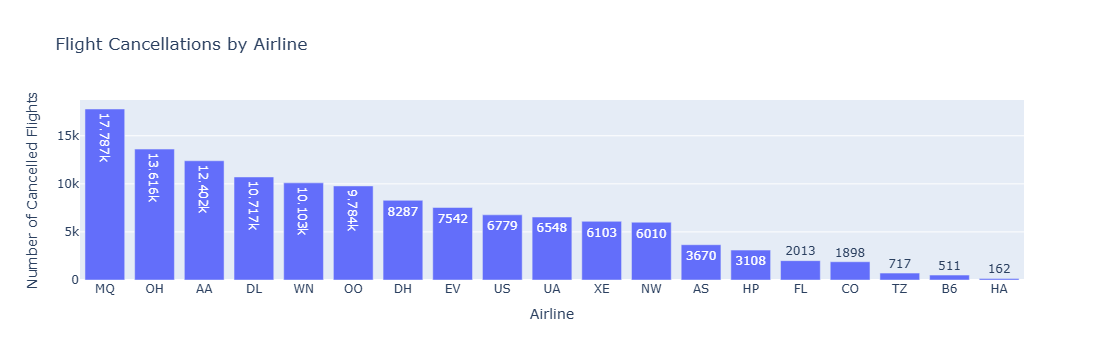

In [45]:
# Visualize
fig = px.bar(df_airline_cancel, x='airline', y='cancelled_flights', text_auto=True, title='Flight Cancellations by Airline')
fig.update_layout(xaxis_title='Airline', yaxis_title='Number of Cancelled Flights')
fig.show()

From the above graph, we can see that, in 2004, MQ Airline had the most cancelled flights. Referring to [U.S./BTS](https://www.transtats.bts.gov/FieldInfo.asp?Svryq_Qr5p=h0v37r%FDPn44vr4%FDP1qr.%FDjur0%FD6ur%FD5nzr%FDp1qr%FDun5%FDorr0%FD75rq%FDoB%FDz7y6v2yr%FDpn44vr45%FP%FDn%FD07zr4vp%FD57ssvA%FDv5%FD75rq%FDs14%FDrn4yvr4%FD75r45%FP%FDs14%FDrAnz2yr%FP%FDcN%FP%FDcN%FLE%FM%FP%FDcN%FLF%FM.%FDh5r%FD6uv5%FDsvryq%FDs14%FDn0nyB5v5%FDnp4155%FDn%FD4n0tr%FD1s%FDBrn45.&Svryq_gB2r=Pun4&Y11x72_gnoyr=Y_haVdhR_PNeeVRef&gnoyr_VQ=FGJ&flf_gnoyr_anzr=g_bagVZR_eRcbegVaT&fB5_Svryq_anzr=bc_haVdhR_PNeeVRe), MQ is Envoy Air. PSA Airlines Inc. (OH) and 	American Airlines Inc. (AA) are also among the airlines that had the most cancelled flights. These carriers might have operated high-volume regional routes prone to weather disruptions or operational constraints.

**b) Cancellations by Airport**

In [50]:
query9 = """SELECT
  origin AS airport,
  COUNT(*) AS cancelled_flights
FROM df_cancelled
WHERE cancelled = 1
GROUP BY origin
ORDER BY cancelled_flights DESC
LIMIT 10
"""

cancelled_airport = pd.read_sql(query9, conn)
cancelled_airport

,airport,cancelled_flights
0,ORD,11725
1,ATL,7870
2,CVG,5656
3,DFW,5535
4,LGA,4347
5,EWR,3883
6,BOS,3332
7,IAD,2856
8,PHL,2853
9,LAX,2508


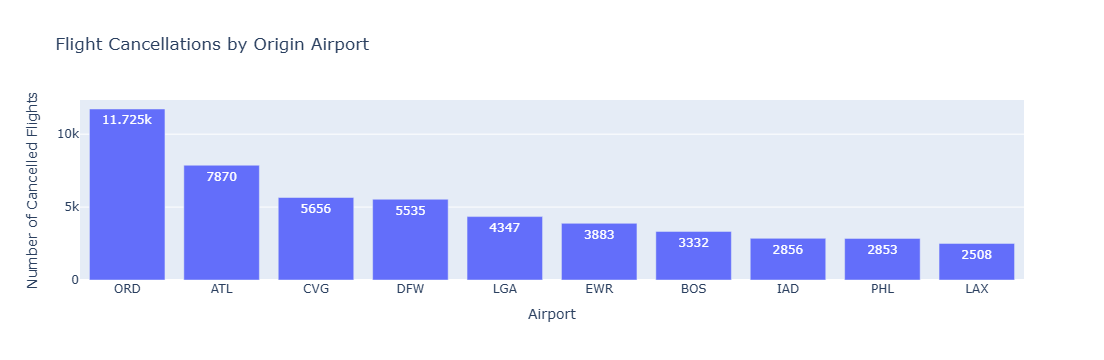

In [51]:
# Visualize

fig = px.bar(cancelled_airport, x='airport', y='cancelled_flights', text_auto=True, title='Flight Cancellations by Origin Airport')
fig.update_layout(xaxis_title='Airport', yaxis_title='Number of Cancelled Flights')
fig.show()

Based on above analysis, ORD airport had the most cancelled flights. In contrast, the LAX airport had the least number of cancelled flights. Busy hubs like ORD (Chicago O’Hare) are more sensitive to ripple effects of weather, congestion, and connecting flights. This is deduced based on Chicago's inconsistent weather, as discussed in the [Climate of Chicago, Illinois: The What and Why of Every Season](https://theclare.com/blog/climate-chicago-illinois/#:~:text=The%20polar%20jet%20stream%E2%80%94a,temperatures%20in%20winter%20and%20summer.) article. 

**c) Cancellations by Month**

In [52]:
query10 = """SELECT
  month,
  COUNT(*) AS cancelled_flights
FROM df_cancelled
WHERE cancelled = 1
GROUP BY month
ORDER BY month
"""

cancelled_month = pd.read_sql(query10, conn)
cancelled_month

,month,cancelled_flights
0,1,17611
1,2,9481
2,3,7603
3,4,4485
4,5,10381
5,6,8796
6,7,10132
7,8,10163
8,9,17969
9,10,6695


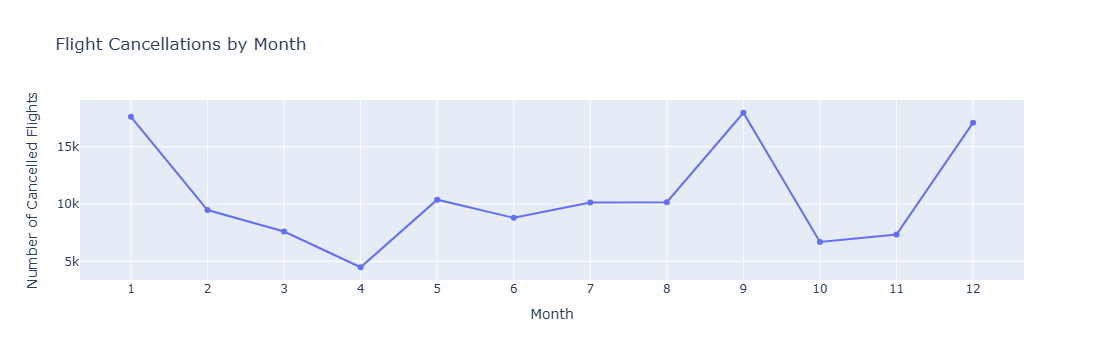

In [53]:
# Visualize

fig = px.line(cancelled_month, x='month', y='cancelled_flights', markers=True, title='Flight Cancellations by Month')
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Cancelled Flights', xaxis=dict(tickmode='linear'))
fig.show()

Above analysis shows clear seasonal patterns, where peaks occurred in January, September, and December, and the lowest in April. This could possibly due to winter storms in January and December, and potential operational adjustments in September, which may have contributed to spikes.

**d) Cancellations by Time of Day**

In [54]:
query11 = """SELECT
  CASE
    WHEN crs_dep_time >= 0 AND crs_dep_time < 600 THEN 'Early Morning'
    WHEN crs_dep_time >= 600 AND crs_dep_time < 1200 THEN 'Morning'
    WHEN crs_dep_time >= 1200 AND crs_dep_time < 1800 THEN 'Afternoon'
    ELSE 'Evening/Night'
  END AS time_of_day,
  COUNT(*) AS cancelled_flights
FROM df_cancelled
WHERE cancelled = 1
GROUP BY
  CASE
    WHEN crs_dep_time >= 0 AND crs_dep_time < 600 THEN 'Early Morning'
    WHEN crs_dep_time >= 600 AND crs_dep_time < 1200 THEN 'Morning'
    WHEN crs_dep_time >= 1200 AND crs_dep_time < 1800 THEN 'Afternoon'
    ELSE 'Evening/Night'
  END
ORDER BY cancelled_flights DESC
"""

cancelled_time_of_day = pd.read_sql(query11, conn)
cancelled_time_of_day

,time_of_day,cancelled_flights
0,Afternoon,51782
1,Morning,44368
2,Evening/Night,30053
3,Early Morning,1554


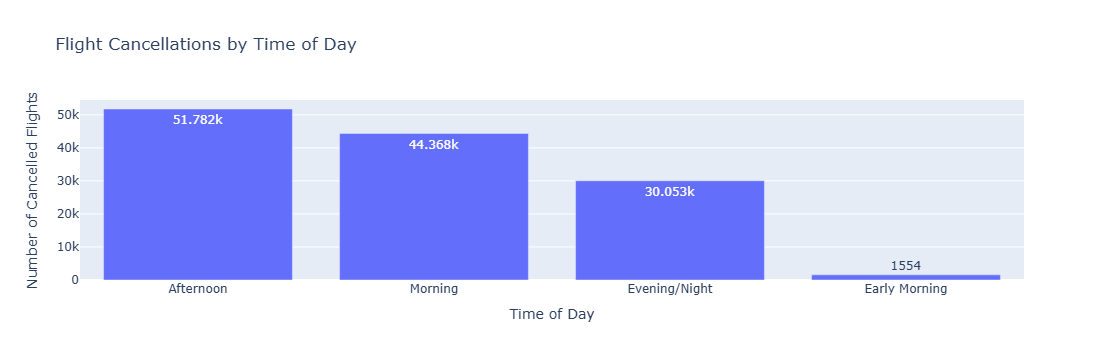

In [55]:
# Visualize

fig = px.bar(cancelled_time_of_day, x='time_of_day', y='cancelled_flights', text_auto=True, title='Flight Cancellations by Time of Day')
fig.update_layout(xaxis_title='Time of Day', yaxis_title='Number of Cancelled Flights')
fig.show()

Our analysis above shows that flights scheduled in Afternoon and Morning are the ones that mostly got cancelled, in 2004. This could be related to the fact that afternoon flights and morning flights would be delayed the most. 

**Overall Summary on Cancellation Correlation**

Based on the 2004 dataset, flight cancellations clearly correlate with certain airlines, origin airports, and time patterns. The visualizations indicate that specific carriers and airports contributed significantly to the total cancellations. Seasonal trends and times of day further show when cancellations were most likely to occur, providing actionable insights for future operational improvements. Identifying these patterns helps airlines and airports proactively manage resources, adjust schedules, and minimize passenger disruptions.

### 4. Problematic Routes

1. Identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance.
2. Analyse the reasons these particular flights are prone to delays or cancellations.

*In order to identify and analyse the "problematic" aspects like specific routes, carriers or flight numbers, we will be looking
at **BOTH** delayed flights and cancelled flights. Hence, the df_delay and df_cancelled will be combined.*

Before we combine the datasets, we first need to add column to flag each datasets as "Delay = 1 or Delay = 0" and "Cancelled = 1 or Cancelled = 0"

In [30]:
# Create a version with delay flag = 1, cancelled flag = 0 

# Drop if exists
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS df_delay_aligned")
cursor.close()

query_delay_aligned = """
CREATE TABLE df_delay_aligned AS
SELECT
  year,
  month,
  day_of_month,
  origin,
  dest,
  unique_carrier,
  flight_num,
  arr_delay,
  carrier_delay,
  weather_delay,
  nas_delay,
  security_delay,
  late_aircraft_delay,
  1 AS delay,
  0 AS cancelled,
  NULL AS cancellation_code
FROM df_delay
"""

cursor = conn.cursor()
cursor.execute(query_delay_aligned)
cursor.close()

In [31]:
# Create a version with delay flag = 0, cancelled flag = 1

# Drop if exists
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS df_cancelled_aligned")
cursor.close()

query_cancelled_aligned = """
CREATE TABLE df_cancelled_aligned AS
SELECT
  year,
  month,
  day_of_month,
  origin,
  dest,
  unique_carrier,
  flight_num,
  NULL AS arr_delay,
  NULL AS carrier_delay,
  NULL AS weather_delay,
  NULL AS nas_delay,
  NULL AS security_delay,
  NULL AS late_aircraft_delay,
  0 AS delay,
  1 AS cancelled,
  cancellation_code
FROM df_cancelled
"""

cursor = conn.cursor()
cursor.execute(query_cancelled_aligned)
cursor.close()

In [32]:
# Drop if exist
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS df_new")
cursor.close()

query_new = """
CREATE TABLE df_new AS
SELECT * FROM df_delay_aligned
UNION ALL
SELECT * FROM df_cancelled_aligned
"""
cursor = conn.cursor()
cursor.execute(query_new)
cursor.close()

# Quick check — preview a few rows
df_new_preview = pd.read_sql("SELECT * FROM df_new LIMIT 5", conn)
df_new_preview

,df_new.year,df_new.month,df_new.day_of_month,df_new.origin,df_new.dest,df_new.unique_carrier,df_new.flight_num,df_new.arr_delay,df_new.carrier_delay,df_new.weather_delay,df_new.nas_delay,df_new.security_delay,df_new.late_aircraft_delay,df_new.delay,df_new.cancelled,df_new.cancellation_code
0,2004,1,12,ORD,CLT,UA,462,-14.0,0.0,0.0,0.0,0.0,0.0,1,0,None
1,2004,1,13,ORD,CLT,UA,462,-4.0,0.0,0.0,0.0,0.0,0.0,1,0,None
2,2004,1,14,ORD,CLT,UA,462,5.0,0.0,0.0,0.0,0.0,0.0,1,0,None
3,2004,1,15,ORD,CLT,UA,462,-16.0,0.0,0.0,0.0,0.0,0.0,1,0,None
4,2004,1,16,ORD,CLT,UA,462,3.0,0.0,0.0,0.0,0.0,0.0,1,0,None


**df_new Sanity Check**

In [33]:
query_count_delay = "SELECT COUNT(*) AS total FROM df_delay"
df_delay_count = pd.read_sql(query_count_delay, conn)
print("df_delay rows:", df_delay_count['total'][0])

df_delay rows: 6987729


In [34]:
query_count_cancelled = "SELECT COUNT(*) AS total FROM df_cancelled"
df_cancelled_count = pd.read_sql(query_count_cancelled, conn)
print("df_cancelled rows:", df_cancelled_count['total'][0])

df_cancelled rows: 127757


In [35]:
query_count_combined = "SELECT COUNT(*) AS total FROM df_new"
df_combined_count = pd.read_sql(query_count_combined, conn)
print("df_combined rows:", df_combined_count['total'][0])

df_combined rows: 7115486


In [36]:
# See all column names
pd.read_sql("SHOW COLUMNS IN df_new", conn)

,field
0,year
1,month
2,day_of_month
3,origin
4,dest
5,unique_carrier
6,flight_num
7,arr_delay
8,carrier_delay
9,weather_delay


#### 1a. Top 5 Most Problematic Flight Routes

In [52]:
query_problematic_routes = """
WITH route_stats AS (
  SELECT
    origin,
    dest,
    unique_carrier,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN arr_delay > 0 THEN 1 ELSE 0 END) AS total_delays,
    SUM(cancelled) AS total_cancellations
  FROM df_new
  WHERE arr_delay > 0 OR cancelled = 1
  GROUP BY origin, dest, unique_carrier
)
SELECT *
FROM route_stats
ORDER BY (total_delays + total_cancellations) DESC
LIMIT 5
"""

cursor = conn.cursor()
cursor.execute(query_problematic_routes)
df_problematic_routes = cursor.fetchall()
cursor.close()

In [57]:
# To display the df
cursor.execute(query_problematic_routes)
results = cursor.fetchall()
columns = ['origin', 'dest', 'unique_carrier', 'total_flights', 'total_delays', 'total_cancellations']
df_problematic_routes = pd.DataFrame(results, columns=columns)
cursor.close()

print(df_problematic_routes)

  origin dest unique_carrier  total_flights  total_delays  total_cancellations
0    HOU  DAL             WN           4977          4388                  589
1    DAL  HOU             WN           4947          4465                  482
2    ATL  LGA             DL           3636          3500                  136
3    LAS  PHX             WN           3557          3363                  194
4    OAK  LAX             WN           3459          3336                  123


In [65]:
# Combine origin-dest for route labels
df_problematic_routes['route'] = df_problematic_routes['origin'] + '-' + df_problematic_routes['dest']
df_problematic_routes

,origin,dest,unique_carrier,total_flights,total_delays,total_cancellations,route
0,HOU,DAL,WN,4977,4388,589,HOU-DAL
1,DAL,HOU,WN,4947,4465,482,DAL-HOU
2,ATL,LGA,DL,3636,3500,136,ATL-LGA
3,LAS,PHX,WN,3557,3363,194,LAS-PHX
4,OAK,LAX,WN,3459,3336,123,OAK-LAX


**Visualize Problematic Flight Routes**

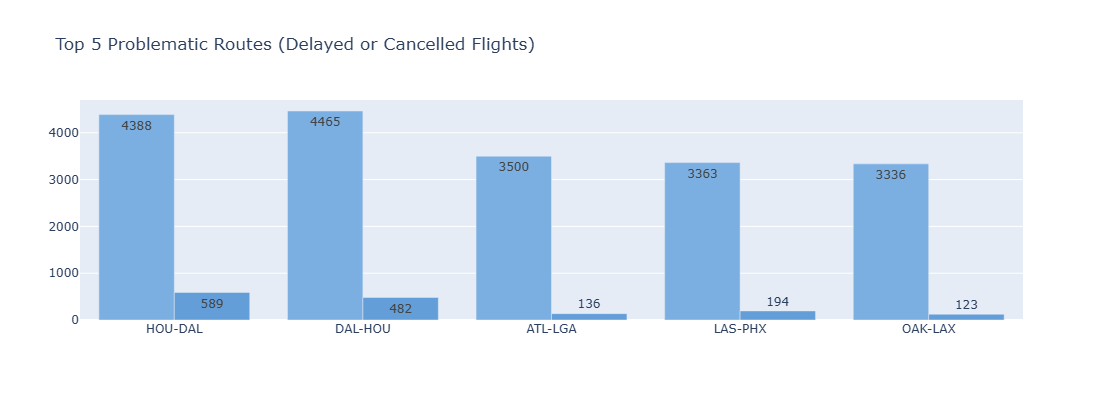

In [68]:
# Plot total delays
fig = go.Figure()
fig.add_trace(go.Bar(x=df_problematic_routes['route'], y=df_problematic_routes['total_delays'],
                     text=df_problematic_routes['total_delays'], marker=dict(color='#7bafe2'), name='Total Delays'))

# Plot total cancellations
fig.add_trace(go.Bar(x=df_problematic_routes['route'], y=df_problematic_routes['total_cancellations'],
                     text=df_problematic_routes['total_cancellations'], marker=dict(color='#639ed8'), name='Total Cancellations'))

# Layout tweaks
fig.update_layout(height=400, barmode = 'group', title_text="Top 5 Problematic Routes (Delayed or Cancelled Flights)", showlegend=False)

fig.show()

##### Problematic Routes Analysis (2004)

The grouped bar chart shows the top 5 origin–destination routes with the highest total number of delays or cancellations. The group bar represents different events (delayed or cancelled) summed together for a full "problematic" picture. For easy comparison, the total delays and total cancellations are plotted side by side.

**Our analysis:**
- Routes like HOU–DAL and DAL–HOU have very high delay counts and non-trivial cancellations, making them the most problematic.
- Some routes, like ATL–LGA, have a high delay count but a relatively small cancellation count, showing that operational reliability is more about managing delays than preventing cancellations there.
- Combining both factors of delayed flights and cancelled flights provides us a comprehensive view of route reliability issues.
- Routes with high counts for both delays and cancellations are likely suffering from multiple operational challenges — weather, congestion, or carrier factors — and could be priorities for improvement.

#### 1b. Top 5 Problematic Carriers

In [53]:
query_carrier_delay = """
WITH carrier_stats AS (
  SELECT
    unique_carrier,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN arr_delay > 0 THEN 1 ELSE 0 END) AS total_delays,
    SUM(cancelled) AS total_cancellations
  FROM df_new
  WHERE arr_delay > 0 OR cancelled = 1
  GROUP BY unique_carrier
)
SELECT *
FROM carrier_stats
ORDER BY (total_delays + total_cancellations) DESC
LIMIT 5
"""
cursor = conn.cursor()
cursor.execute(query_carrier_delay)
df_problematic_carriers = cursor.fetchall()
cursor.close()

In [58]:
# To display the df
cursor.execute(query_carrier_delay)
results = cursor.fetchall()
columns = ['unique_carrier', 'total_flights', 'total_delays', 'total_cancellations']
df_problematic_carriers = pd.DataFrame(results, columns=columns)
cursor.close()

print(df_problematic_carriers)

  unique_carrier  total_flights  total_delays  total_cancellations
0             WN         421315        411212                10103
1             DL         353269        342552                10717
2             AA         305671        293269                12402
3             NW         239560        233550                 6010
4             MQ         229164        211377                17787


**Visualize Problematic Carriers**

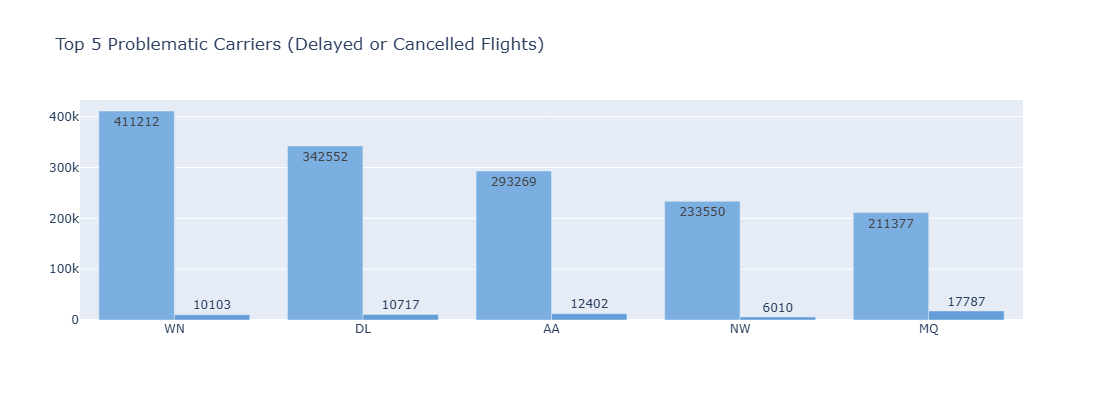

In [69]:
# Plot total delays
fig = go.Figure()
fig.add_trace(go.Bar(x=df_problematic_carriers['unique_carrier'], y=df_problematic_carriers['total_delays'],
                     text=df_problematic_carriers['total_delays'], marker=dict(color='#7bafe2'), name='Total Delays'))

# Plot total cancellations
fig.add_trace(go.Bar(x=df_problematic_carriers['unique_carrier'], y=df_problematic_carriers['total_cancellations'],
                     text=df_problematic_carriers['total_cancellations'], marker=dict(color='#639ed8'), name='Total Cancellations'))

# Layout tweaks
fig.update_layout(height=400, barmode = 'group', title_text="Top 5 Problematic Carriers (Delayed or Cancelled Flights)", showlegend=False)

fig.show()

##### Problematic Carriers Analysis (2004)

The grouped bar chart shows the top 5 airlines with the highest number of flights that were delayed or cancelled. The same concept from previous analysis is applied here.

**Our analysis:**
- **WN (Southwest Airlines)** has the largest number of delays, indicating widespread late departures or arrivals but relatively fewer cancellations.
- **DL (Delta)** and **AA (American Airlines)** follow a similar pattern.
- **MQ (Envoy Air)** stands out for having the highest cancellation count among these top carriers, suggesting different operational challenges compared to the majors, like weather, regional connection challenges, or scheduling issues.
- Overall:
  - delays are a far more frequent issue than cancellations across major US carriers, reflecting how airlines prefer to delay rather than cancel flights when disruptions occur.
  - We can also see that airlines with very high delays but low cancellations may have capacity or scheduling inefficiencies but manage to operate flights instead of cancelling outright.
  - An airline with both high delays and higher cancellations (like MQ) might have struggled with more disruptive issues like resource limitations or reliance on smaller regional airports.

#### 1c. Top 5 Most Problematic Flights

In [59]:
query_flight_delay = """
WITH flight_stats AS (
  SELECT
    flight_num,
    unique_carrier,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN arr_delay > 0 THEN 1 ELSE 0 END) AS total_delays,
    SUM(cancelled) AS total_cancellations
  FROM df_new
  WHERE arr_delay > 0 OR cancelled = 1
  GROUP BY flight_num, unique_carrier
)
SELECT *
FROM flight_stats
ORDER BY (total_delays + total_cancellations) DESC
LIMIT 5
"""
cursor = conn.cursor()
cursor.execute(query_flight_delay)
df_problematic_flights = cursor.fetchall()
cursor.close()

In [62]:
# To display the df
cursor.execute(query_flight_delay)
results = cursor.fetchall()
columns = ['flight_num ','unique_carrier', 'total_flights', 'total_delays', 'total_cancellations']
df_problematic_flights = pd.DataFrame(results, columns=columns)
cursor.close()

print(df_problematic_flights)

  flight_num  unique_carrier  total_flights  total_delays  total_cancellations
0        1406             WN            901           899                    2
1        2020             WN            837           834                    3
2         574             WN            827           820                    7
3         530             HP            817           800                   17
4        2546             WN            816           812                    4


In [64]:
df_problematic_flights['flight_label'] = df_problematic_flights['flight_num '].astype(str) + ' (' + df_problematic_flights['unique_carrier'] + ')'
df_problematic_flights

,flight_num,unique_carrier,total_flights,total_delays,total_cancellations,flight_label
0,1406,WN,901,899,2,1406 (WN)
1,2020,WN,837,834,3,2020 (WN)
2,574,WN,827,820,7,574 (WN)
3,530,HP,817,800,17,530 (HP)
4,2546,WN,816,812,4,2546 (WN)


**Visualize Problematic Flights**

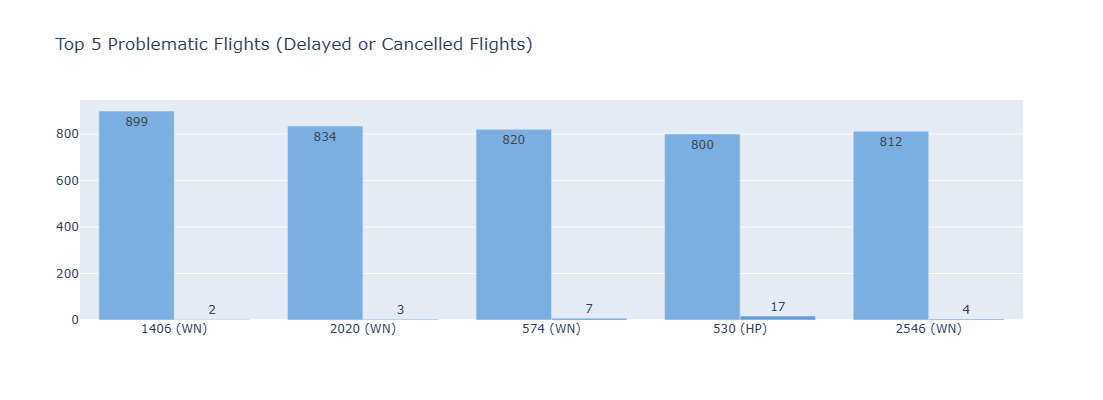

In [70]:
# Plot total delays
fig = go.Figure()
fig.add_trace(go.Bar(x=df_problematic_flights['flight_label'], y=df_problematic_flights['total_delays'],
                     text=df_problematic_flights['total_delays'], marker=dict(color='#7bafe2'), name='Total Delays'))

# Plot total cancellations
fig.add_trace(go.Bar(x=df_problematic_flights['flight_label'], y=df_problematic_flights['total_cancellations'],
                     text=df_problematic_flights['total_cancellations'], marker=dict(color='#639ed8'), name='Total Cancellations'))

# Layout tweaks
fig.update_layout(height=400, barmode = 'group', title_text="Top 5 Problematic Flights (Delayed or Cancelled Flights)", showlegend=False)

fig.show()

##### Problematic Flights Analysis (2004)

The grouped bar chart shows the top 5 individual flight numbers with the highest number of delays or cancellations combined.

**Our analysis:**
- **WN Flight 1406** was the most problematic, with 899 delays and 2 cancellations.
- Other Southwest Airlines flights (WN 2020, WN 574, WN 2546) all experienced 800+ delays, highlighting recurring on-time performance issues.
- **HP Flight 530** had 800 delays and also higher 17 cancellations, suggesting possible operational or route-specific challenges.
- Overall:
  - Delays are the dominant factor for problematic flights, while cancellations are rare for these specific flight numbers. This suggests these flights regularly operate but struggle to stay on schedule, pointing to potential issues like high route demand, tight scheduling, or frequent ground delays.